In [ ]:
import pickle
import torch
import numpy as np
import sys
import time

from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce


from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score,balanced_accuracy_score #roc_auc_score,precision_score,recall_score,f1_score,classification_report

from sklearn.utils import class_weight
import pyriemann
import ot

import myimporter
from BCI_functions import *  # BCI_functions.ipynb contains some functions we might use multiple times in this tutorial
import warnings
warnings.filterwarnings('ignore')
import os
os.getcwd()

In [ ]:
# TODO: This class if has list of subject id can later support combination of sub ids
# TODO: add a function transform to convert dataset to train test, avoiding repetition of same code

class EEGMMIDTrSet(Data.Dataset):
    def __init__(self, subject_id, transform=None):
        root_dir = "../Deep-Learning-for-BCI/dataset/"
        dataset_raw = np.load(root_dir + str(subject_id) + '.npy')
        dataset=[]  # feature after filtering

        # EEG Gamma pattern decomposition
        for i in range(dataset_raw[:,:-1].shape[1]):
            x = dataset_raw[:, i]
            fs = 160.0
            lowcut = 8.0
            highcut = 30.0
            y = butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
            dataset.append(y)
        dataset=np.array(dataset).T
        dataset=np.hstack((dataset,dataset_raw[:,-1:]))
        print(dataset.shape)
        # keep 4,5 which are left and right fist open close imagery classes, remove rest
        # refer 1-Data.ipynb for the details
        removed_label = [0,1,6,7,8,9,10]  # [0,1,2,3,4,5,10] for hf # [0,1,6,7,8,9,10] for lr
        for ll in removed_label:
            id = dataset[:, -1]!=ll
            dataset = dataset[id]

        # Pytorch needs labels to be sequentially ordered starting from 0
        dataset[:, -1][dataset[:, -1] == 2] = 0
        dataset[:, -1][dataset[:, -1] == 4] = 0
        dataset[:, -1][dataset[:, -1] == 3] = 1
        dataset[:, -1][dataset[:, -1] == 5] = 1
        
        # data segmentation
        n_class = 2 #int(11-len(removed_label))  # 0~9 classes ('10:rest' is not considered)
        no_feature = 64  # the number of the features
        segment_length = 160 #160  # selected time window; 16=160*0.1
        
        #Overlapping is removed to avoid training set overlap with test set
        data_seg = extract(dataset, n_classes=n_class, n_fea=no_feature, 
                           time_window=segment_length, moving=(segment_length))  # /2 for 50% overlapping
        print('After segmentation, the shape of the data:', data_seg.shape)

        # split training and test data
        no_longfeature = no_feature*segment_length
        data_seg_feature = data_seg[:, :no_longfeature]
        self.data_seg_label = data_seg[:, no_longfeature:no_longfeature+1]
        
        # Its important to have random state set equal for Training and test dataset
        train_feature, test_feature, train_label, test_label = train_test_split(
            data_seg_feature, self.data_seg_label,random_state=0, shuffle=True,stratify=self.data_seg_label)

        # Check the class label splits to maintain balance
        unique, counts = np.unique(self.data_seg_label, return_counts=True)
        left_perc = counts[0]/sum(counts)
        if left_perc < 0.4 or left_perc > 0.6:
            print("Imbalanced dataset with split of: ",left_perc,1-left_perc)
        else:
            print("Classes balanced.")
        unique, counts = np.unique(train_label, return_counts=True)
        print("Class label splits in training set \n ",np.asarray((unique, counts)).T)
        unique, counts = np.unique(test_label, return_counts=True)
        print("Class label splits in test set\n ",np.asarray((unique, counts)).T)



        # normalization
        # before normalize reshape data back to raw data shape
        train_feature_2d = train_feature.reshape([-1, no_feature])
        test_feature_2d = test_feature.reshape([-1, no_feature])

        scaler1 = StandardScaler().fit(train_feature_2d)
        train_fea_norm1 = scaler1.transform(train_feature_2d) # normalize the training data
        test_fea_norm1 = scaler1.transform(test_feature_2d) # normalize the test data
        print('After normalization, the shape of training feature:', train_fea_norm1.shape,
              '\nAfter normalization, the shape of test feature:', test_fea_norm1.shape)
        
        # This is to select only MI related channels
        train_fea_norm1 = train_fea_norm1[:,:21]
        test_fea_norm1 = test_fea_norm1[:,:21]
        no_feature = 21

        
        # after normalization, reshape data to 3d
        train_fea_norm1 = train_fea_norm1.reshape([-1, segment_length, no_feature])
        test_fea_norm1 = test_fea_norm1.reshape([-1, segment_length, no_feature])
        print('After reshape, the shape of training feature:', train_fea_norm1.shape,
              '\nAfter reshape, the shape of test feature:', test_fea_norm1.shape)
        
        # reshape for data shape: (trial, conv channel, electrode channel, time samples)
        # earlier it was (trial,timesamples,electrode_channel)
        train_fea_reshape1 = np.swapaxes(train_fea_norm1,1,2)
        test_fea_reshape1 = np.swapaxes(test_fea_norm1,1,2)
        print('After expand dims, the shape of training feature:', train_fea_reshape1.shape,
              '\nAfter expand dims, the shape of test feature:', test_fea_reshape1.shape)
        
        self.data = train_fea_reshape1 # torch.tensor(train_fea_reshape1)
        self.targets = train_label.flatten() #torch.tensor(train_label.flatten()).long()
        
        print("data and target type:",type(self.data),type(self.targets))


    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data, target = self.data[idx], self.targets[idx]
        return data, target
    
    def get_class_weights(self):
        class_weights=class_weight.compute_class_weight('balanced',np.unique(self.data_seg_label),
                                                        self.data_seg_label[:,0])
        return class_weights



In [ ]:
class EEGMMIDTsSet(Data.Dataset):
    def __init__(self, subject_id, transform=None):
        root_dir = "../Deep-Learning-for-BCI/dataset/"
#         dataset = np.load(root_dir + str(subject_id) + '.npy')
        dataset_raw = np.load(root_dir + str(subject_id) + '.npy')
        dataset=[]  # feature after filtering

        # EEG Gamma pattern decomposition
        for i in range(dataset_raw[:,:-1].shape[1]):
            x = dataset_raw[:, i]
            fs = 160.0
            lowcut = 8.0
            highcut = 30.0
            y = butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
            dataset.append(y)
        dataset=np.array(dataset).T
        dataset=np.hstack((dataset,dataset_raw[:,-1:]))
        # keep 4,5 which are left and right fist open close imagery classes, remove rest
        # refer 1-Data.ipynb for the details
        removed_label = [0,1,6,7,8,9,10]  # [0,1,2,3,4,5,10] for hf # [0,1,6,7,8,9,10] for lr
        for ll in removed_label:
            id = dataset[:, -1]!=ll
            dataset = dataset[id]

        # Pytorch needs labels to be sequentially ordered starting from 0
        dataset[:, -1][dataset[:, -1] == 2] = 0
        dataset[:, -1][dataset[:, -1] == 4] = 0
        dataset[:, -1][dataset[:, -1] == 3] = 1
        dataset[:, -1][dataset[:, -1] == 5] = 1
        
        # data segmentation
        n_class = 2 #int(11-len(removed_label))  # 0~9 classes ('10:rest' is not considered)
        no_feature = 64  # the number of the features
        segment_length = 160 #160  # selected time window; 16=160*0.1
        
        #Overlapping is removed to avoid training set overlap with test set
        data_seg = extract(dataset, n_classes=n_class, n_fea=no_feature, 
                           time_window=segment_length, moving=(segment_length))  # /2 for 50% overlapping
        print('After segmentation, the shape of the data:', data_seg.shape)

        # split training and test data
        no_longfeature = no_feature*segment_length
        data_seg_feature = data_seg[:, :no_longfeature]
        data_seg_label = data_seg[:, no_longfeature:no_longfeature+1]
        # Its important to have random state set equal for Training and test dataset
        train_feature, test_feature, train_label, test_label = train_test_split(
            data_seg_feature, data_seg_label,random_state=0, shuffle=True,stratify=data_seg_label)

        # Check the class label splits to maintain balance
        unique, counts = np.unique(data_seg_label, return_counts=True)
        left_perc = counts[0]/sum(counts)
        if left_perc < 0.4 or left_perc > 0.6:
            print("Imbalanced dataset with split of: ",left_perc,1-left_perc)
        else:
            print("Classes balanced.")
        unique, counts = np.unique(train_label, return_counts=True)
        print("Class label splits in training set \n ",np.asarray((unique, counts)).T)
        unique, counts = np.unique(test_label, return_counts=True)
        print("Class label splits in test set\n ",np.asarray((unique, counts)).T)



        # normalization
        # before normalize reshape data back to raw data shape
        train_feature_2d = train_feature.reshape([-1, no_feature])
        test_feature_2d = test_feature.reshape([-1, no_feature])

        scaler1 = StandardScaler().fit(train_feature_2d)
        train_fea_norm1 = scaler1.transform(train_feature_2d) # normalize the training data
        test_fea_norm1 = scaler1.transform(test_feature_2d) # normalize the test data
        print('After normalization, the shape of training feature:', train_fea_norm1.shape,
              '\nAfter normalization, the shape of test feature:', test_fea_norm1.shape)
        
        # This is to select only MI related channels
        train_fea_norm1 = train_fea_norm1[:,:21]
        test_fea_norm1 = test_fea_norm1[:,:21]
        no_feature = 21

        # after normalization, reshape data to 3d
        train_fea_norm1 = train_fea_norm1.reshape([-1, segment_length, no_feature])
        test_fea_norm1 = test_fea_norm1.reshape([-1, segment_length, no_feature])
        print('After reshape, the shape of training feature:', train_fea_norm1.shape,
              '\nAfter reshape, the shape of test feature:', test_fea_norm1.shape)
        
        
        
        # reshape for data shape: (trial, conv channel, electrode channel, time samples)
        # earlier it was (trial,timesamples,electrode_channel)
        train_fea_reshape1 = np.swapaxes(train_fea_norm1,1,2)
        test_fea_reshape1 = np.swapaxes(test_fea_norm1,1,2)
        print('After expand dims, the shape of training feature:', train_fea_reshape1.shape,
              '\nAfter expand dims, the shape of test feature:', test_fea_reshape1.shape)
        
        self.data =  test_fea_reshape1#torch.tensor(test_fea_reshape1)
        self.targets = test_label.flatten() #torch.tensor(test_label.flatten()).long()
        
        print("data and target type:",type(self.data),type(self.targets))

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data, target = self.data[idx], self.targets[idx]
        return data, target


In [ ]:
def get_class_acc(confusion_matrix, class_id):
    """
    confusion matrix of multi-class classification
    
    class_id: id of a particular class 
    
    """
    confusion_matrix = np.float64(confusion_matrix)
    TP = confusion_matrix[class_id,class_id]
    FN = np.sum(confusion_matrix[class_id]) - TP
    FP = np.sum(confusion_matrix[:,class_id]) - TP
    TN = np.sum(confusion_matrix) - TP - FN - FP
    print("for class id: ",class_id)
    print(f"TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN} ")
    
    # sensitivity = 0 if TP == 0
    if TP != 0:
        sensitivity = TP/(TP+FN)
    else:
        sensitivity = 0.
    
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    
    return sensitivity, specificity, accuracy

In [ ]:
def train_eegmmid(task_type, strat, sub_id, i=""):
    
    start = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_ds = EEGMMIDTrSet(subject_id=sub_id)
    test_ds = EEGMMIDTsSet(subject_id=sub_id)
    
    # compute covariance matrices on training data
    cov_mi_21 = pyriemann.estimation.Covariances('oas').transform(train_ds[:][0])
    labels = train_ds[:][1]
    
    mdm = pyriemann.classification.MDM(metric=dict(mean='riemann', distance='riemann'))
    
    # cross validation
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    # Use scikit-learn Pipeline with cross_val_score function
    scores = cross_val_score(mdm, cov_mi_21, labels, cv=cv, n_jobs=1)
    
    
    ccov_mi_21_test = pyriemann.estimation.Covariances('oas').transform(test_ds[:][0])
    mdm = mdm.fit(cov_mi_21, labels)
    y_pred = mdm.predict(ccov_mi_21_test)
    cm = confusion_matrix(test_ds[:][1], y_pred)
    
    acc_0 = get_class_acc(cm,0)
    acc_1 = get_class_acc(cm,1)
    acc = accuracy_score(test_ds[:][1], y_pred)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("train acc: ",scores)
    print("test acc: ",acc, acc_0, acc_1)
    print("chance level acc: ",class_balance)
    
    results = []
    thisresults = []

    print(i + ".")
    
    
    thisresults.append({"task_type":task_type,
                                "strategy":strat,
                                "sub_id":sub_id,
                                "iteration":i,
                                "chance level acc":class_balance,
                                "acc":acc,
                                "acc0":acc_0[0],
                                "acc1":acc_1[0] })
    results.append({"task_type":task_type,
                    "strategy":strat,
                    "sub_id":sub_id,
                    "iteration":i,
                    "results":thisresults})
    elapsed = time.time() - start
#     results.append({"time":elapsed})
    with open("./results/riem_mi/eegmmid_ws_" + strat +"_"+ str(sub_id)+ "_results" + i + ".pkl", "wb") as outfile:
        pickle.dump(results, outfile)
    print("\t" + str(elapsed) + " seconds")



In [ ]:
for s_id in range(1,110):#[7,15,29,32,35,42,43,46,48,49,54,56,62,93,94,108]: #range(7,18):
    print("\n --------------------------------------------------- \n")
    print("Starting for subject id:",s_id)
    for itr in range(5):
        train_eegmmid(task_type="within_sub",strat="riem_mi", sub_id=s_id, i=str(itr))

## Helper code to understand POT

32.075695526612385
27.42815732338359
23.247264446931645
20.155954615433366
18.899752123114215
20.15595461496293
23.2472644464981
27.428157323383605
32.0756955266124


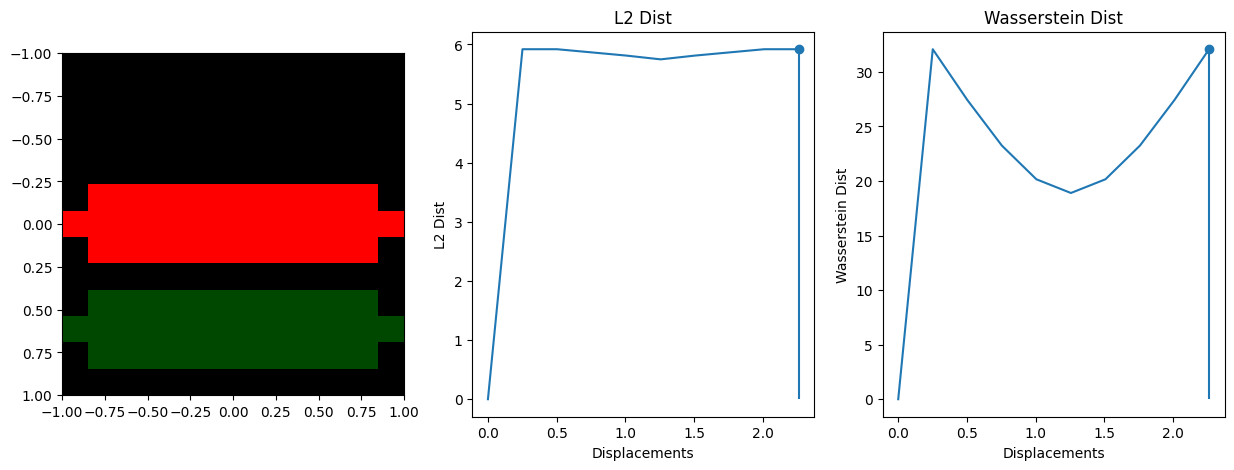

In [192]:
"""
Programmer: Chris Tralie
Purpose: To use the POT library (https://github.com/rflamary/POT)
to compute the Entropic regularized Wasserstein distance 
between points on a 2D grid
"""
import numpy as np
import matplotlib.pyplot as plt
import ot

def testMovingDisc():
    """
    Show optimal transport on a moving disc in a 50x50 grid
    """
    ## Step 1: Setup problem
    pix = np.linspace(-1, 1, 13)
    # Setup grid
    X, Y = np.meshgrid(pix, pix)
    # Compute pariwise distances between points on 2D grid so we know
    # how to score the Wasserstein distance
    coords = np.array([X.flatten(), Y.flatten()]).T
    coordsSqr = np.sum(coords**2, 1)
    M = coordsSqr[:, None] + coordsSqr[None, :] - 2*coords.dot(coords.T)
    M[M < 0] = 0
    M = np.sqrt(M)
    ts = np.linspace(-0.8, 0.8, 10)
    
    ## Step 2: Compute L2 distances and Wasserstein
    Images = []
    radius = 0.2
    L2Dists = [0.0]
    WassDists = [0.0]
    for i, t in enumerate(ts):
        I = 1e-5 + np.roll(topo_pred, i,0)#np.array(((X<radius+1.0) & (X>-0.5)) & ((Y<t+ radius) & (Y>t)), dtype=float)#np.array((X-t)**2 + (Y-t)**2 < radius**2, dtype=float)
        I /= np.sum(I)
        Images.append(I)
        Images[0] = 1e-5 +topo_true
        if i > 0:
            L2Dists.append(np.sqrt(np.sum((I-Images[0])**2)))
            wass = ot.sinkhorn2(Images[0].flatten(), I.flatten(), M, 1.0)#sinkhorn2
            print(wass)
            WassDists.append(wass)
    
    ## Step 3: Make Animation
    L2Dist = np.array(L2Dists)
    WassDists = np.array(WassDists)
    I0 = Images[0]
    plt.figure(figsize=(15, 5))
    displacements = np.sqrt(2)*(ts - ts[0])
    for i, I in enumerate(Images):
        plt.clf()
        D = np.concatenate((I0[:, :, None], I[:, :, None]*10, 0*I[:, :, None]), 2)
        D = D*255/np.max(I0)
        D = np.array(D, dtype=np.uint8)
        plt.subplot(131)
        plt.imshow(D, extent = (pix[0], pix[-1], pix[-1], pix[0]))
        plt.subplot(132)
        plt.plot(displacements, L2Dists)
        plt.stem([displacements[i]], [L2Dists[i]])
        plt.xlabel("Displacements")
        plt.ylabel("L2 Dist")
        plt.title("L2 Dist")
        plt.subplot(133)
        plt.plot(displacements, WassDists)
        plt.stem([displacements[i]], [WassDists[i]])
        plt.xlabel("Displacements")
        plt.ylabel("Wasserstein Dist")
        plt.title("Wasserstein Dist")
        plt.savefig("%i.png"%i, bbox_inches='tight')

if __name__ == '__main__':
    testMovingDisc()